We are playing 20 questions.

The user (person) thinks about any term, person or object, and the computer (AI) has to guess it by asking up to 20 yes-or-no questions.
You will answer only using yes or no.
If the computer guesses the term in less than 20 questions, it wins.
If the computer does not guess the term in 20 questions, it loses.

The way the computer plays the game is by utilizing the large context window of the newest Gemini model - 2 million tokens! It has access to the full textual content of Wikipedia. That's ~6.5 million documents or approximatelly 6 billion tokens (that's just for the english version).

When asking the first questions, the whole wikipedia dataset still won't fit into the context window, so the computer will use `faiss` to search for the most relevant documents to the question and then use the top documents to ask the next question.

Once the computer can narrow the context fown to ~2 million tokens, it will start using the full context window to ask the following questions.

- Load the wikipedia dataset from https://www.kaggle.com/datasets/jjinho/wikipedia-20230701
- Embed the documents into `faiss` 
- Ask the user to think of something (and not to tell us!)
- Start guessing loop
  - If this is the first round, just ask a random question (ask gemini to propose a good yes\no question to start a game of 20 questions)
  - If this is not the first round, try 


In [2]:
!pip install pandas==1.5.3 numpy==1.23.5 faiss-cpu ipywidgets kagglehub google.generativeai python-dotenv matplotlib pandasai seaborn PyYAML


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
INFO: pip is looking at multiple versions of faiss-cpu to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 11.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 12.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
  Attempting uninstall: faiss-cpu
    Found existing installation: faiss-cpu 1.9.0.post1
    Uninstalling faiss-cpu-1.9.0.post1:
      Successfully uninstalled faiss-cpu-1.9.0.post1


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jrobischon/wikipedia-movie-plots")

print("Path to dataset files:", path)

Path to dataset files: /home/lizozom/.cache/kagglehub/datasets/jrobischon/wikipedia-movie-plots/versions/1


This part creates the faiss index and loads the wikipedia dataset.
No need to run this part, as the faiss index is attached.
The code is here just for context.

In [79]:
import pandas as pd

# Load the dataset
data_path = f"{path}/wiki_movie_plots_deduped.csv"
df = pd.read_csv(data_path)
print(f"Dataset loaded successfully, contains {len(df)}")


Dataset loaded successfully, contains 34886


In [ ]:
def count_words(string):
    words = string.split()
    return len(words)

total_characters = 0 
for plot in df['Plot']:
    total_characters += count_words(plot)

total_characters

In [ ]:
# Inspect the structure
print(df.columns)

# Ensure the text column is correctly identified
text_column = "Plot"  # Replace with the actual column name in your dataset

# Calculate total memory usage in bytes
column_total_size = df[text_column].memory_usage(deep=True)

# Convert to megabytes (optional)
total_size_mb = column_total_size / (1024 ** 2)

print(f"Total size of the DataFrame: {total_size_mb} bytes ({total_size_mb:.2f} MB)")

In [ ]:
def generate_question(history, context):
    prompt = f"""
    You are playing 20 Questions. Based on:
    - Question history: {history}
    - Context: {context}
    Ask the most relevant yes/no question.
    """
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response["choices"][0]["message"]["content"]

game_state = {"questions": [], "responses": []}
question = generate_question(game_state["questions"], "Wikipedia")


In [ ]:
from ipywidgets import widgets, interact, VBox

def ask_question():
    question = generate_question(game_state["questions"], "Wikipedia context")
    game_state["questions"].append(question)
    return question

def on_submit(change):
    response = input_box.value
    game_state["responses"].append(response)
    indices, distances = search_candidates(" ".join(game_state["questions"]))
    candidates = [chunks[i] for i in indices[0]]
    question_label.value = ask_question()
    input_box.value = ""

question_label = widgets.Label(value="Think of a word. Let’s begin!")
input_box = widgets.Text()
input_box.observe(on_submit, names='value')

display(VBox([question_label, input_box]))


### Define the chat model

In [88]:
import os
import google.generativeai as genai
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

genai.configure(api_key=os.environ["GEMINI_API_KEY"])

generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-pro",
  generation_config=generation_config,
)

chat_session = model.start_chat(
  history=[
  ]
)


### Clean the data - Remove unknowns, fix genres and cast formats

Replacing 'sci-fi' with 'science fiction'
Replacing 'sci fi' with 'science fiction'
Replacing 'superheros' with 'superhero'
Replacing 'lgbt-themed' with 'lgbt'
Replacing 'world war ii' with 'war'
Replacing 'world war i' with 'war'
Replacing 'martial artss' with 'martial arts'
Replacing 'martial art' with 'martial arts'
Replacing 'animated short' with 'animation'
Replacing 'animated' with 'animation'
Total number of movies after cleaning: 28803


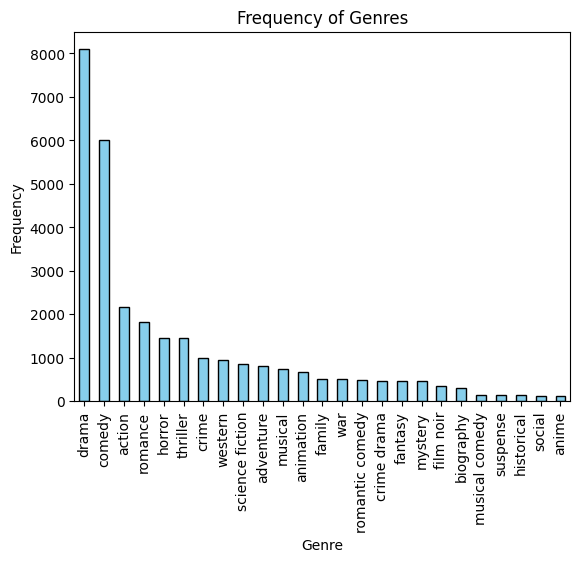

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

SEPARATORS = [
    "–", "-", "/"
]

GENRE_TERM_MAPPING = {
    "sci-fi": "science fiction",
    "sci fi": "science fiction",
    "superheros": "superhero",  
    "lgbt-themed": "lgbt",
    "world war ii": "war",
    "world war i": "war",
    "martial artss": "martial arts",
    "martial art": "martial arts",
    "animated short": "animation",
    "animated": "animation",
}
    
df['Genre_clean'] = df['Genre']

df = df[df['Genre_clean'] != 'unknown']

for term in GENRE_TERM_MAPPING:
    print(f"Replacing '{term}' with '{GENRE_TERM_MAPPING[term]}'")
    df['Genre_clean'] = df['Genre_clean'].str.replace(term, GENRE_TERM_MAPPING[term])
    
for sep in SEPARATORS:
    df['Genre_clean'] = df['Genre_clean'].str.replace(sep, ", ", regex=False)

all_genres = df['Genre_clean'].str.split(', ').apply(lambda x: [item.strip() for item in x]).explode()
print(f"Total number of movies after cleaning: {len(df)}")

# Count occurrences of each genre
genre_counts = all_genres.value_counts().head(25)

# print(genre_counts)

# Plot bar chart
genre_counts.plot.bar(color='skyblue', edgecolor='black', title="Frequency of Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=90)  # Rotate labels for better visibility
plt.show()

In [84]:

df['Cast_clean'] = df['Cast']
df['Cast_clean'] = df['Cast_clean'].str.replace("\n", ", ", regex=False)



### Create example context prompt

In [ ]:
cleaned_df = df
subset_movies = cleaned_df.sample(50)

context_prompt = ""
for idx, line in subset_movies.iterrows():
    cur_prompt = f"""
    Movie id: {idx}
    Movie Name: {line['Title']}
    Release Year: {line['Release Year']}
    Origin/Ethnicity: {line['Origin/Ethnicity']}
    Director: {line["Director"]}
    Cast: {line["Cast"]}
    Genres: {line['Genre_clean']}
    Plot: {line["Plot"]}
    --------------------------------------------------------------------------
    """
    context_prompt += cur_prompt

print(context_prompt[:500])



    Movie id: 11978
    Movie Name: Ethan Frome
    Release Year: 1993
    Origin/Ethnicity: American
    Director: John Madden
    Cast: Liam Neeson, Patricia Arquette, Joan Allen
    Genres: drama
    Plot: Reverend Smith has arrived in Starkfield from Boston. He notices that Ethan Frome is isolated. Smith encourages his parishioners to be charitable.
Ethan and Zeena Pierce are distant cousins. After marrying Zeena, Ethan falls in love with Mattie Silver.
    --------------------------------


In [101]:
previous_questions = []
previous_questions_text = '\\n'.join(previous_questions) if len(previous_questions) > 0 else 'No previous questions.'

In [102]:
final_prompt = f"""
You are an Analytical thinker and Pattern recognition expert.
You are given a set of movies, where each is built using the following pattern:

Movie id: unique identifier of each movie.
Movie Name: The name of the movie.
Release Year: Year the movie was released.
Origin/Ethnicity: The ethnicity of the movie.
Director: Full name of the director.
Case: Partial cast names.
Genre: The Genre of the movie.
Plot: The plot of the movie.

Your task is to create a yes no question that divides the movies into two groups. One ground for the answer "yes" and one group for the answer "no".
Aim for questions that cut the number of movies in half.
Aim for questions that are not similar to previous questions.
The question should be short, concise and clear.
It should also be a bit whimsical and fun to engage the players.
The division must be according to one of the following fields: 
    - Movie name
    - Release Year
    - Origin/Ethnicity
    - Director
    - Case
    - Genre
    - Plot

Set of movies: 

{context_prompt}

Previous questions:

{previous_questions_text}

Return the following in YAML format (don't add quotes or yaml around the content):

question: The yes/no question.
answer_yes_group: List of movie ids that answer "yes".
answer_no_group: List of movie ids that answer "no".
"""

In [103]:
response = chat_session.send_message(final_prompt)

In [106]:
import yaml
parsed_response = yaml.safe_load(response.text.replace("```yaml\n", "").replace("\n```", ""))
print(parsed_response["question"])
previous_questions.append(parsed_response["question"])


Does the movie feature a heartwarming or hilarious family at its core?


Next each question needs to be converted to pandas-ai to apply the question condition on the total dataset. 
Repeat the process until all the context fits the model's max context window

In [105]:
import os
from pandasai import SmartDataframe
from pandasai.llm import GoogleGemini


In [76]:

llm = GoogleGemini(os.environ["GEMINI_API_KEY"])
new_df = df[["Title", "Release Year", "Cast", "Plot"]]

smart_df = SmartDataframe(cleaned_df, config={"llm": llm})


In [108]:


smart_df.chat("Get all movies that don't feature a heartwarming or hilarious family at its core")

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Genre_clean,Cast_clean
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,western,NaN
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,comedy,NaN
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,short,NaN
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...,short action/crime western,NaN
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,short film,NaN
...,...,...,...,...,...,...,...,...,...,...
34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he...",drama film,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the...",comedy,"Ahmet Kural, Murat Cemcir"
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i...",comedy,"Ata Demirer, Tuvana Türkay, Ülkü Duru"
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...,romantic comedy,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl..."
